# Multi-label image prediction with Planet Amazon dataset from kaggle

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai import *
from fastai.vision import *

## Creating directory for the data

In [3]:
print(Config.data_path())

/home/jupyter/.fastai/data


In [4]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [6]:
# Download data from kaggle (if haven't done so yet)
# ! pip install kaggle --upgrade

In [7]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [8]:
# Install 7zip to extract the files downloaded above 
# (if haven't done so yet):
# ! conda install -y -c haasad eidl7zip

In [8]:
# Now unpack the data if haven't done so yet
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Multiclassification

For the planets competition, each picture can have multiple labels. 

In [9]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Using flip_vert=true is a sensible augmentation for satellite pics -- satellite images should be recognizable regardless of whether they are "upside down" or not. This is different from the case of recognizing most side-facing images, where we would very seldom expect to have situations where a truck, or building would need to be recognized from an upside down point of view.

In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [6]:
np.random.seed(42)
src = (ImageFileList.from_folder(path)
      .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')
      .random_split_by_pct(0.2))

In [7]:
data = (src.datasets()
       .transform(tfms, size=128)
       .databunch().normalize(imagenet_stats))

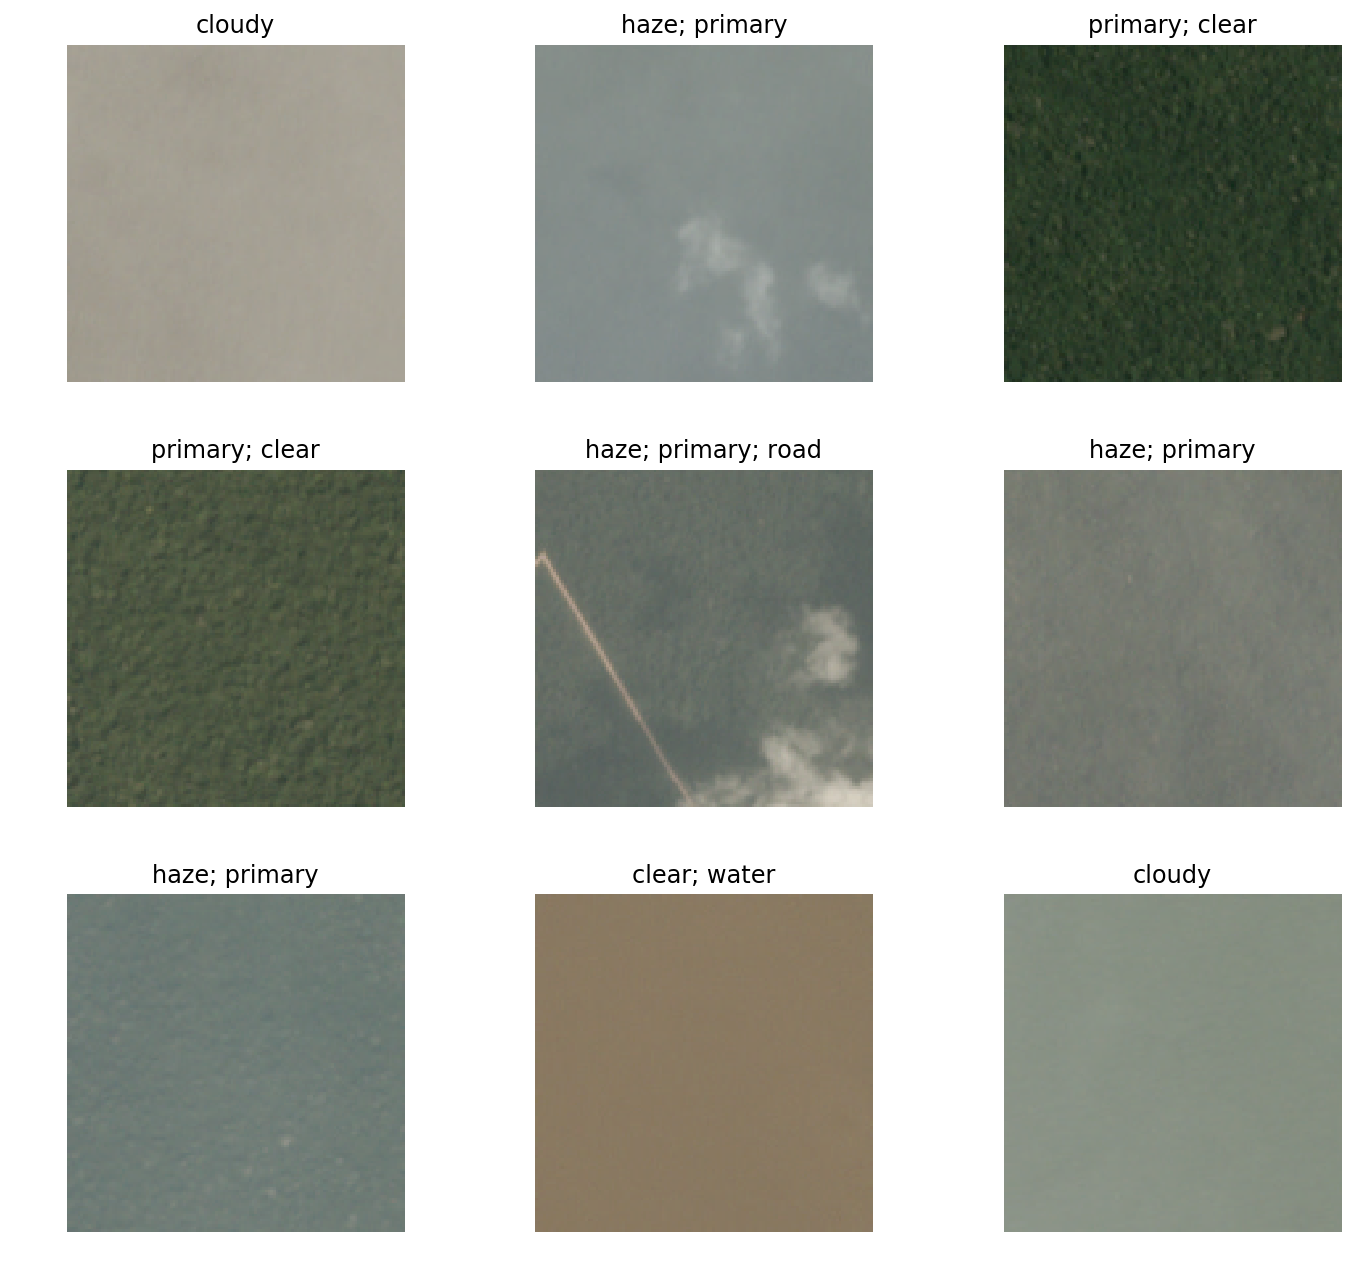

In [17]:
data.show_batch(rows=3, figsize=(10,9))

Because the different classes are *not* mutually exclusive, we need to select a threshold that defines how high a probability for any category must be before we will make the prediction that the picture indeed contains that category, such as fog, agriculture, etc.

In [8]:
arch = models.resnet50

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [10]:
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

## Training

In [18]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


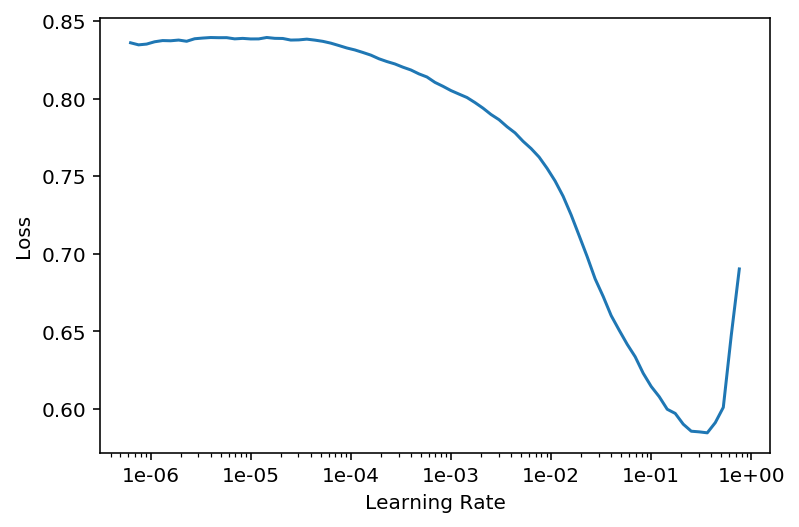

In [19]:
learn.recorder.plot()

First, let's fit the head of our network.

In [20]:
lr = 0.01

In [21]:
learn.fit_one_cycle(5, slice(lr))

Total time: 09:00
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.115896    0.102927    0.951946         0.911688  (01:48)
2      0.109320    0.100252    0.952883         0.910782  (01:47)
3      0.102201    0.090357    0.953850         0.920841  (01:48)
4      0.092293    0.086097    0.956683         0.926230  (01:47)
5      0.087944    0.084653    0.957468         0.928276  (01:47)



In [22]:
learn.save('stage-1-rn50')

Now we can fine-tune all the layers of the network.

In [23]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


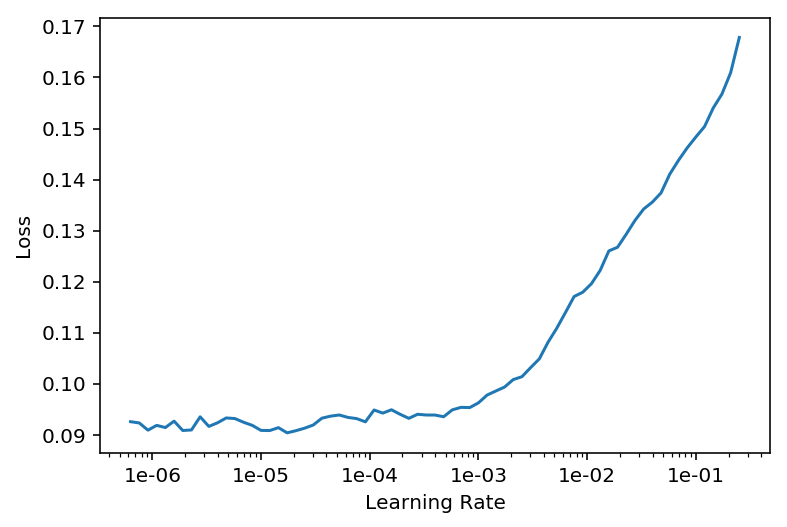

In [24]:
learn.lr_find()
learn.recorder.plot()

Pick an lr range that begins with an lr about 10 times smaller than the point on the above graph where loss begins to shoot up.

In [25]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 11:47
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.093154    0.088034    0.957577         0.923624  (02:21)
2      0.092349    0.088743    0.954932         0.925308  (02:21)
3      0.091795    0.085792    0.956233         0.925551  (02:21)
4      0.083619    0.083061    0.959452         0.927971  (02:21)
5      0.082798    0.082412    0.958253         0.929199  (02:21)



In [26]:
learn.save('stage-2-rn50')

Now let's train at double the image size.

In [11]:
bs=32

data = (src.datasets()
       .transform(tfms, size=256)
       .databunch(bs=bs).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [12]:
learn.load('stage-2-rn50')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7fdcfe066470>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [13]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


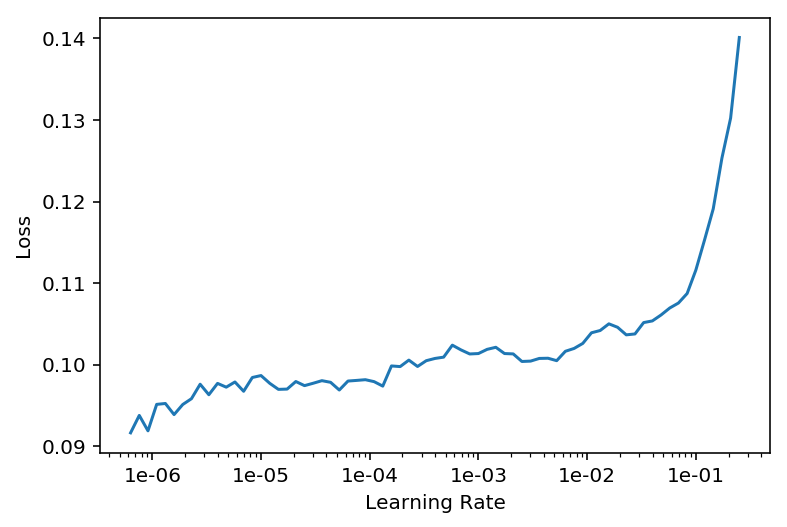

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
lr=1e-2/2

In [16]:
learn.fit_one_cycle(5, slice(lr))

Total time: 32:47
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.092850    0.090703    0.959081         0.917426  (06:34)
2      0.095619    0.088336    0.957803         0.926065  (06:33)
3      0.090084    0.084303    0.958013         0.928453  (06:33)
4      0.085737    0.082870    0.960404         0.929595  (06:33)
5      0.082658    0.082418    0.960615         0.929982  (06:33)



In [17]:
learn.save('stage-1-256-rn50')

In [18]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


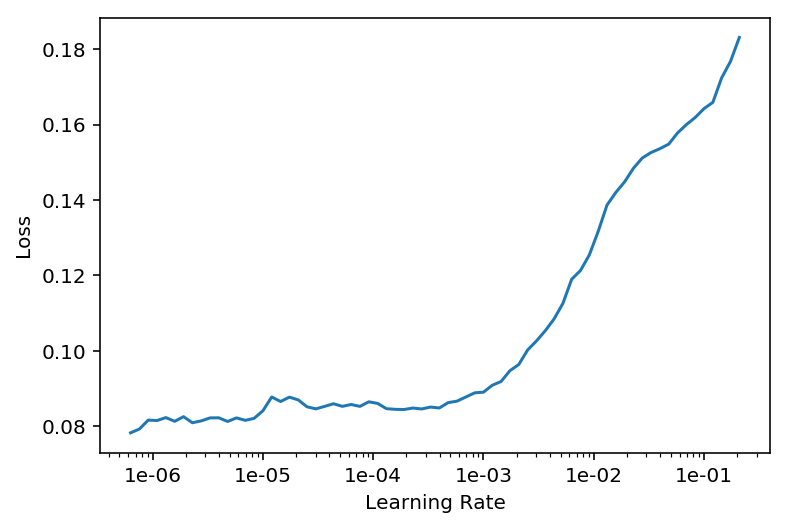

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 42:53
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.093601    0.086391    0.958529         0.926224  (08:34)
2      0.090520    0.086666    0.957156         0.923857  (08:34)
3      0.094217    0.082631    0.958268         0.929420  (08:34)
4      0.078074    0.083175    0.960411         0.928676  (08:34)
5      0.083611    0.083774    0.960251         0.930171  (08:34)



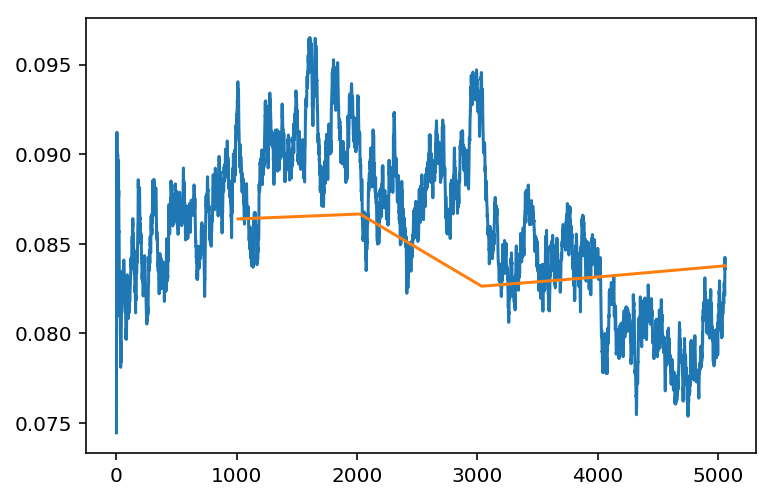

In [21]:
learn.recorder.plot_losses()

In [22]:
learn.save('stage-2-256-rn50')